# Part 1: The Jester Dataset

For the Alternating Least Squares and Stochastic Gradient Descent matrix factorization recommendation systems, the notebooks will be using [the Jester dataset](https://www.kaggle.com/crawford/jester-online-joke-recommender#jesterfinal151cols.csv) hosted on Kaggle. This notebook introduces the dataset, performs some initial analysis, and creates a train / test datset.

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import PIL
import random
import sklearn
import scipy

random.seed(42)
np.random.seed(42)

The jester dataset is a recommendation dataset which consists of user ratings for a set of 150 jokes. Users were asked to rate a subset of these jokes on a scale from -10 to 10. The responses for each user are recorded in the rows. The u,i-th row records the rating of joke i for user u. Therefore, this matrix is of dimension U X I, where U is the number of users in the study, and I is the number of jokes in the dataset. The first column is a metadata column that will be discarded. Read in the data.

**Note**: The final row in the dataset appeared to be corrupted row when downloading from Kaggle. The row has been removed from the dataset. No other modifications were made. 

In [2]:
ratings_mat = pd.read_csv('datasets/jester/jesterfinal151cols.csv', header=None)
del ratings_mat[0]
print('The number of users in this dataset is {0}'.format(ratings_mat.shape[0]))
print('The number of jokes in this dataset is {0}'.format(ratings_mat.shape[1]))

The number of users in this dataset is 50691
The number of jokes in this dataset is 150


The first column of the dataset represents the number of valid ratings from a particular user. That is, if the first column has a value of '3', the user has rated 3 jokes in the dataset. If a user has not rated a joke, the value will be '99'. Plot a histogram to see the distribution of user ratings and joke ratings.

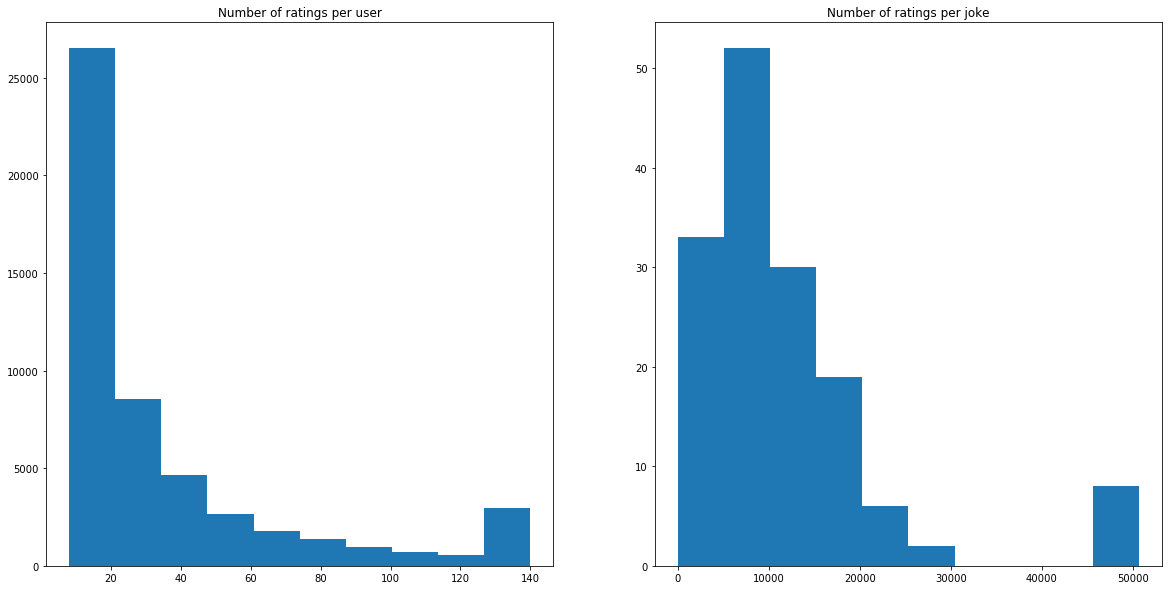

In [3]:
user_rating_counts = ratings_mat[ratings_mat < 50].count(axis=1)
joke_rating_counts = ratings_mat[ratings_mat < 50].count()

fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax_left.hist(user_rating_counts)
ax_left.set_title('Number of ratings per user')
ax_right.hist(joke_rating_counts)
ax_right.set_title('Number of ratings per joke')

plt.show()

It is interesting that each user has rated at least 15 jokes. This makes this dataset somewhat unusual. In addition, there are a few jokes that appear to have been rated much more frequently than the rest of the jokes. Another statistic of interest is the fill ratio, which is the ratio of the number of user-item ratings that exist in the dataset to the total possible number of user-item ratings. 

In [4]:
fill_ratio = np.sum(ratings_mat[ratings_mat < 50].count()) * 100
fill_ratio /= (ratings_mat.shape[0] * ratings_mat.shape[1])
print('The ratings matrix is {0:.2f}% full.'.format(fill_ratio))

The ratings matrix is 22.74% full.


We see that the fill ratio is almost 23%, which is unusually high. Most datasets have fill ratios in the single digits. [This website](https://www.kdnuggets.com/2016/02/nine-datasets-investigating-recommender-systems.html) gives a good overview of a few popular datasets. There, we can see that many of the datasets have fill ratios of less than 5%. 

In order to make processing easier in the following notebooks, the following transformations will be applied to the dataset:
* Unrated jokes will be given the value 0 instead of 99. This is because the consuming algorithms will make heavy use of the dot product. Giving unrated jokes the values of 0 will remove them from the calculation.
* The rating range of [-10, 10] will be converted to [1, 5]. This is so a rated value of '0' can be distinguished from an unrated value of 0.
* The array will be converted to a numpy array. The pandas features are no longer needed.

In [5]:
ratings_mat *= 0.2
ratings_mat += 3
ratings_mat.replace(22.8, 0, inplace=True)

ratings_mat = ratings_mat.values

# TODO: allow insert own joke ratings

Now that the dataset has been generated, it is time to split into a training and testing set. For the testing set, one review from each user will be selected at random. This review will be removed from the training set. The datasets will then be written to a sparse matrix on disk, to be consumed in future notebooks.

In [6]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        rated_items = ratings[user, :].nonzero()[0] 
        test_ratings = np.random.choice(rated_items, 
                                        size=1, 
                                        replace=False)
        
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

train_set, test_set = train_test_split(ratings_mat)

scipy.sparse.save_npz('datasets/train.dat', scipy.sparse.csc_matrix(train_set))
scipy.sparse.save_npz('datasets/test.dat', scipy.sparse.csc_matrix(test_set))